Notes:
* dask GroupBy tuning https://youtu.be/QY0zFsaO2j8

In [1]:
import dask.dataframe as dd
import pandas as pd

from distributed import Client, progress, wait

import dask
import os

In [2]:
os.chdir('../..')
dask.config.set(temporary_directory=os.getcwd())
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41911,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.30 GiB
Comm: tcp://127.0.0.1:40119,Total threads: 3
Dashboard: http://127.0.0.1:40239/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:35073,


In [3]:
def vehicle_grouper(df, groupby_sort=True, agg_shuffle=None):
    '''Get summary data for each vehicle'''
    vehicle_df = (
        df
        .groupby('vehicle_id',
                 sort=groupby_sort, # True, False
                )
        .agg({'make':'last',
              'model':'last',
              'fuel_type':'last',
              'cylinder_capacity':'last',
              'first_use_date':'last',
              'test_date':'max',
              'test_mileage':'max',
             },
             shuffle=agg_shuffle, # None, 'disk', 'tasks', 'p2p'
            )
    )
    return vehicle_df

def add_lifetime(df):
    '''Get vehicle lifespan (vehicle may or may not still be in service)'''
    df['lifetime'] = dd.to_timedelta((df['test_date'] - df['first_use_date'])).dt.days / 365
    return df

In [4]:
# 30m16s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet",
                    #dtype_backend='pyarrow',
                    #index='vehicle_id',
                    #calculate_divisions=True,
                    #columns=['make', 'model', 'fuel_type', 'cylinder_capacity', 'first_use_date', 'test_date', 'test_mileage'],
                   )
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [5]:
# 29m18s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend='pyarrow')
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [6]:
# 6m55s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result_sorted.parquet",
                    dtype_backend='pyarrow',
                    index='vehicle_id',
                    calculate_divisions=True,
                   )
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle=None)
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [4]:
# 11m02s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result.parquet", dtype_backend='pyarrow')
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper, agg_shuffle='p2p')
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [5]:
# 2m19s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result_sorted.parquet",
                    dtype_backend='pyarrow',
                    index='vehicle_id',
                    calculate_divisions=True,
                   )
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle='p2p')
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [5]:
# 2m15s
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result_sorted.parquet",
                    dtype_backend='pyarrow',
                    index='vehicle_id',
                    calculate_divisions=True,
                    columns=['make', 'model', 'fuel_type', 'cylinder_capacity', 'first_use_date', 'test_date', 'test_mileage'],
                    filters=[("make", "in", ["VOLVO", "VOLKSWAGEN", "ROVER"]),
                             ("model", "in", ["V50", "PASSAT", "200", "200 VI"]),
                            ],
                   )
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=False, agg_shuffle='p2p')
    .pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [9]:
# Lifetime
vehicle_summary_ddf = (
    dd.read_parquet(path="test_result_sorted.parquet",
                    dtype_backend='pyarrow',
                    index='vehicle_id',
                    calculate_divisions=True,
                   )
    .query('make in ["VOLVO", "VOLKSWAGEN", "ROVER"] & model in ["V50", "PASSAT", "200", "200 VI"]')
    .dropna()
    .pipe(vehicle_grouper, groupby_sort=True, agg_shuffle='p2p')
    #.pipe(add_lifetime)
    .persist()
)
progress(vehicle_summary_ddf)

VBox()

In [11]:
vehicle_summary_ddf.head()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage
vehicle_id,,,,,,,
15965343,VOLKSWAGEN,PASSAT,DI,1968,2016-09-08 00:00:00,2020-08-14 00:00:00,60704
16015386,VOLKSWAGEN,PASSAT,DI,1968,2009-12-01 00:00:00,2012-12-01 00:00:00,29929
16195682,VOLKSWAGEN,PASSAT,DI,1896,1998-10-14 00:00:00,2014-06-19 00:00:00,181376
16802350,VOLKSWAGEN,PASSAT,DI,1968,2007-07-17 00:00:00,2020-08-26 00:00:00,163028
17339249,VOLKSWAGEN,PASSAT,DI,1968,2015-11-25 00:00:00,2022-08-30 00:00:00,95958


In [6]:
vehicle_summary_pdf = vehicle_summary_ddf.compute().sort_index()
vehicle_summary_pdf['test_date'] = pd.to_datetime(vehicle_summary_pdf['test_date'])
vehicle_summary_pdf['first_use_date'] = pd.to_datetime(vehicle_summary_pdf['first_use_date'])
vehicle_summary_pdf['surviving'] = vehicle_summary_pdf['test_date'] >= pd.Timestamp('2022-01-01')
vehicle_summary_pdf['surviving_colour'] = vehicle_summary_pdf.surviving.map({True:'blue', False:'red'})
vehicle_summary_pdf['fuel_colour'] = vehicle_summary_pdf.fuel_type.map({'DI':'black', 'PE':'blue', 'HY':'green'})
vehicle_summary_pdf

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
15936727,VOLKSWAGEN,PASSAT,DI,1968,2015-03-18,2022-03-24,116852,7.021918,True,blue,black
15937552,VOLKSWAGEN,PASSAT,DI,1896,2002-04-12,2022-08-26,189291,20.386301,True,blue,black
15937972,VOLKSWAGEN,PASSAT,DI,1968,2006-06-22,2014-07-25,165808,8.095890,False,red,black
15939999,VOLKSWAGEN,PASSAT,DI,1968,2013-06-27,2022-05-30,69146,8.928767,True,blue,black
15940976,VOLKSWAGEN,PASSAT,DI,1968,2006-06-23,2019-08-16,124084,13.156164,False,red,black
...,...,...,...,...,...,...,...,...,...,...,...
1483949071,VOLKSWAGEN,PASSAT,DI,1968,2016-12-30,2019-12-16,91078,2.961644,False,red,black
1483949288,VOLKSWAGEN,PASSAT,DI,1896,2001-12-31,2022-01-07,211678,20.032877,True,blue,black
1483959459,VOLKSWAGEN,PASSAT,DI,1598,2015-12-22,2022-02-25,52099,6.183562,True,blue,black


In [7]:
vehicle_summary_pdf.groupby(['make', 'surviving'])['model'].count()

make        surviving
ROVER       False          7549
            True            183
VOLKSWAGEN  False        336167
            True         202276
VOLVO       False         17147
            True          34668
Name: model, dtype: int64

In [8]:
vehicle_summary_pdf.model.value_counts()

model
PASSAT    538441
V50        51816
200         7134
200 VI       599
Name: count, dtype: Int64

In [9]:
vehicle_summary_pdf.fuel_type.value_counts()

fuel_type
DI    467331
PE    127034
HY      3355
LP       234
EL        26
GB         4
ST         2
OT         2
CN         1
ED         1
Name: count, dtype: Int64

In [10]:
vehicle_summary_pdf.query('model == "200" & test_mileage == 205404')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
1238787680,ROVER,200,PE,1796,1997-09-08,2016-08-16,205404,18.950685,False,red,blue


In [11]:
vehicle_summary_pdf.query('model == "V50" & test_mileage == 171443')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
815632906,VOLVO,V50,DI,1560,2007-12-20,2022-05-03,171443,14.378082,True,blue,black
1042513740,VOLVO,V50,DI,1997,2005-03-10,2022-05-12,171443,17.183562,True,blue,black


In [12]:
vehicle_summary_pdf.query('model == "PASSAT" & test_mileage == 142191')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
633992338,VOLKSWAGEN,PASSAT,DI,1968,2006-05-03,2017-05-16,142191,11.043836,False,red,black
716489940,VOLKSWAGEN,PASSAT,DI,1896,1997-05-22,2006-10-10,142191,9.391781,False,red,black
1162861794,VOLKSWAGEN,PASSAT,PE,1781,2002-03-25,2014-10-29,142191,12.605479,False,red,blue
1354367214,VOLKSWAGEN,PASSAT,PE,1798,1999-01-07,2022-02-08,142191,23.104110,True,blue,blue


In [13]:
vehicle_summary_pdf.query('vehicle_id in [1042513740, 1238787680, 1354367214]')

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
1042513740,VOLVO,V50,DI,1997,2005-03-10,2022-05-12,171443,17.183562,True,blue,black
1238787680,ROVER,200,PE,1796,1997-09-08,2016-08-16,205404,18.950685,False,red,blue
1354367214,VOLKSWAGEN,PASSAT,PE,1798,1999-01-07,2022-02-08,142191,23.104110,True,blue,blue


In [14]:
v50s_df = (
    vehicle_summary_pdf
    .assign(year = vehicle_summary_pdf.first_use_date.dt.year)
    .query('model == "V50" & fuel_type == "DI" & cylinder_capacity == 1997')
    #.query('1997 <= year <= 2001')
)

v50s_df.groupby('year').count()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
year,,,,,,,,,,,
2004,170,170,170,170,170,170,170,170,170,170,170
2005,390,390,390,390,390,390,390,390,390,390,390
2006,355,355,355,355,355,355,355,355,355,355,355
2007,1127,1127,1127,1127,1127,1127,1127,1127,1127,1127,1127
2008,1636,1636,1636,1636,1636,1636,1636,1636,1636,1636,1636
2009,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564,1564
2010,1553,1553,1553,1553,1553,1553,1553,1553,1553,1553,1553
2011,760,760,760,760,760,760,760,760,760,760,760
2012,306,306,306,306,306,306,306,306,306,306,306


In [15]:
passats_df = (
    vehicle_summary_pdf
    .assign(year = vehicle_summary_pdf.first_use_date.dt.year)
    .query('model == "PASSAT" & fuel_type == "PE" & cylinder_capacity == 1798')
    .query('1997 <= year <= 2001')
)

passats_df#.groupby('year').count()

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour,year
vehicle_id,,,,,,,,,,,,
15962324,VOLKSWAGEN,PASSAT,PE,1798,1998-09-20,2011-07-13,144463,12.819178,False,red,blue,1998
16032818,VOLKSWAGEN,PASSAT,PE,1798,2000-06-09,2013-10-05,151824,13.331507,False,red,blue,2000
16460718,VOLKSWAGEN,PASSAT,PE,1798,1998-09-25,2010-10-06,236355,12.038356,False,red,blue,1998
16532790,VOLKSWAGEN,PASSAT,PE,1798,2000-05-11,2015-05-28,118722,15.054795,False,red,blue,2000
17015562,VOLKSWAGEN,PASSAT,PE,1798,2000-06-22,2013-06-24,123528,13.013699,False,red,blue,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
1482303816,VOLKSWAGEN,PASSAT,PE,1798,1999-04-15,2013-08-24,108540,14.369863,False,red,blue,1999
1482555156,VOLKSWAGEN,PASSAT,PE,1798,2000-11-29,2013-07-23,139240,12.654795,False,red,blue,2000
1482922154,VOLKSWAGEN,PASSAT,PE,1798,1999-09-06,2012-10-12,121042,13.109589,False,red,blue,1999


In [16]:
rovers_df = (
    vehicle_summary_pdf
    .query('model in ["200", "200 VI"] & cylinder_capacity == 1796')
)

rovers_df

,make,model,fuel_type,cylinder_capacity,first_use_date,test_date,test_mileage,lifetime,surviving,surviving_colour,fuel_colour
vehicle_id,,,,,,,,,,,
16342432,ROVER,200,PE,1796,2001-07-02,2006-07-11,14928,5.027397,False,red,blue
16784412,ROVER,200,PE,1796,1998-08-25,2009-10-26,98364,11.178082,False,red,blue
17112862,ROVER,200,PE,1796,1997-02-28,2007-02-23,33029,9.991781,False,red,blue
17156984,ROVER,200,PE,1796,1999-09-29,2006-07-17,97006,6.802740,False,red,blue
17512414,ROVER,200,PE,1796,1998-02-11,2009-01-22,100623,10.953425,False,red,blue
...,...,...,...,...,...,...,...,...,...,...,...
1482845934,ROVER,200,PE,1796,1999-09-02,2008-09-13,48373,9.038356,False,red,blue
1483528482,ROVER,200,PE,1796,1998-03-19,2009-02-26,77242,10.950685,False,red,blue
1483552682,ROVER,200,PE,1796,1998-12-31,2010-08-09,69868,11.613699,False,red,blue


(0.0, 250000.0)

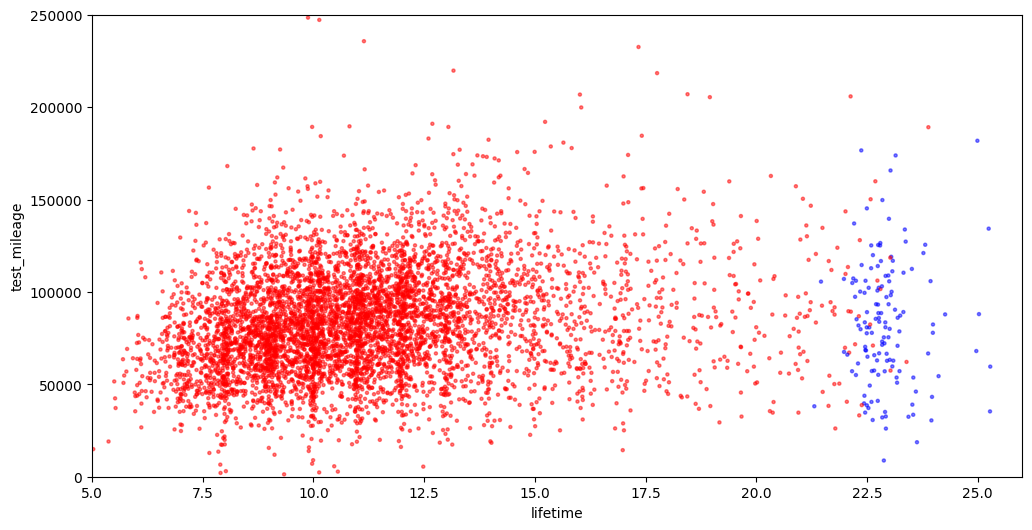

In [17]:
ax = (
    rovers_df
    .dropna()
    .plot.scatter(figsize=(12,6),
                  x='lifetime', y='test_mileage',
                  marker='.',
                  alpha=0.5,
                  #s=0.5,
                  c='surviving_colour'
                 )
)
ax.set_xlim(5,26)
ax.set_ylim(0,250000)

(0.0, 400000.0)

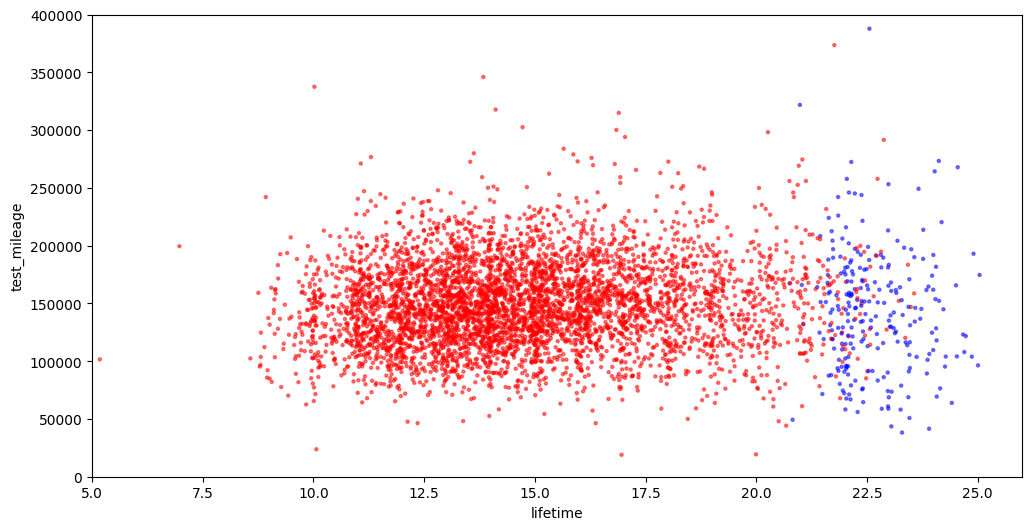

In [18]:
ax = (
    passats_df
    .dropna()
    .plot.scatter(figsize=(12,6),
                  x='lifetime', y='test_mileage',
                  marker='.',
                  alpha=0.5,
                  #s=0.5,
                  c='surviving_colour'
                 )
)
ax.set_xlim(5,26)
ax.set_ylim(0,400000)

In [19]:
passats_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5082 entries, 15962324 to 1483114966
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   make               5082 non-null   string        
 1   model              5082 non-null   string        
 2   fuel_type          5082 non-null   string        
 3   cylinder_capacity  5082 non-null   int64[pyarrow]
 4   first_use_date     5082 non-null   datetime64[ns]
 5   test_date          5082 non-null   datetime64[ns]
 6   test_mileage       5082 non-null   int64[pyarrow]
 7   lifetime           5082 non-null   float64       
 8   surviving          5082 non-null   bool          
 9   surviving_colour   5082 non-null   object        
 10  fuel_colour        5082 non-null   object        
 11  year               5082 non-null   int32         
dtypes: bool(1), datetime64[ns](2), float64(1), int32(1), int64[pyarrow](2), object(2), string(3)
memory usage: 462

Text(0.5, 1.0, 'Passat Survival')

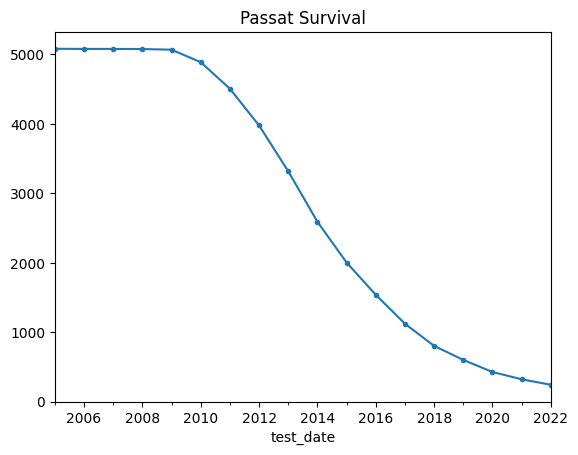

In [20]:
ax = passats_df.resample(on='test_date', rule='1Y').model.count().loc[::-1].cumsum()[::-1].plot(marker='.')
ax.set_title('Passat Survival')

(0.0, 300000.0)

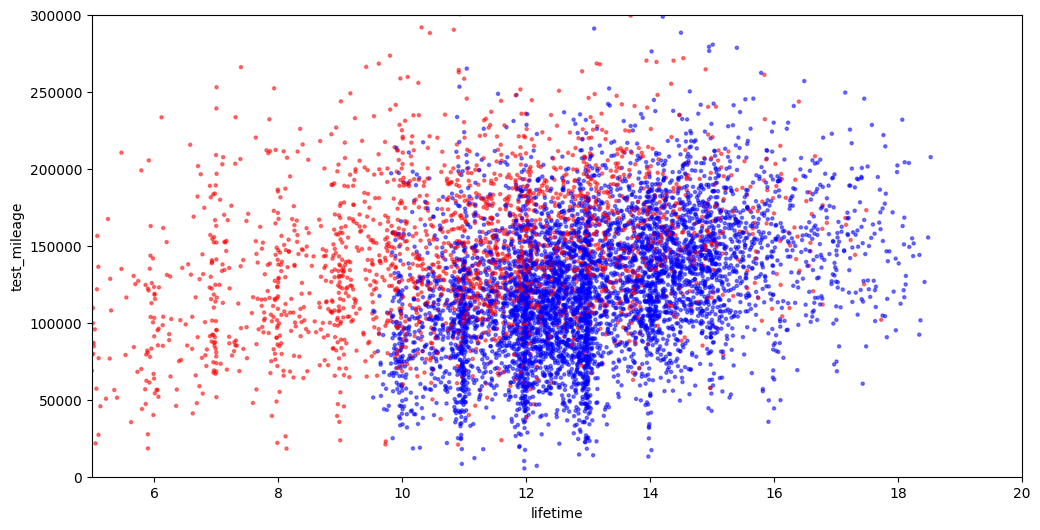

In [21]:
ax = (
    v50s_df
    .dropna()
    .plot.scatter(figsize=(12,6),
                  x='lifetime', y='test_mileage',
                  marker='.',
                  alpha=0.5,
                  #s=0.5,
                  c='surviving_colour'
                 )
)
ax.set_xlim(5,20)
ax.set_ylim(0,300000)

In [22]:
pd.concat([rovers_df, passats_df, v50s_df]).groupby(['make', 'surviving']).model.count()

make        surviving
ROVER       False        5720
            True          136
VOLKSWAGEN  False        4841
            True          241
VOLVO       False        2355
            True         5509
Name: model, dtype: int64